# Logistic Regression Implementation for Image Classification

In this notebook, we will implement a logistic regression model from scratch using NumPy to classify images from the CIFAR-10 dataset. The focus will be on a binary classification task (e.g., detecting whether an image is an "airplane" or "not an airplane").
This code includes data loading and preprocessing, model implementation, training with mini-batches and early stopping, and finally, evaluation and visualization of the results.

## Libraries

In this section, we import all the libraries required to run the code

In [57]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import math

## Data Loading and Preprocessing

In [58]:
def load_and_preprocess_data_logistic(validation_split_ratio=0.1):
    """
    Loads CIFAR-10, applies a fixed subset, normalizes images,
    re-labels for binary classification, and splits training data into train/validation.
    """
    (x_train_orig_full, y_train_orig_full), (x_test_orig_full, y_test_orig_full) = \
        tf.keras.datasets.cifar10.load_data()

    subset_train_size = 50000
    print(f"Initial training subset size: {subset_train_size}")
    x_train_subset_orig = x_train_orig_full[:subset_train_size]
    y_train_subset_orig = y_train_orig_full[:subset_train_size]

    subset_test_size = 10000
    print(f"Using test subset of size: {subset_test_size}")
    x_test_subset_orig = x_test_orig_full[:subset_test_size]
    y_test_subset_orig_int_labels = y_test_orig_full[:subset_test_size]

    x_train_normalized = x_train_subset_orig.astype('float32') / 255.0
    x_test_normalized = x_test_subset_orig.astype('float32') / 255.0

    x_train_flattened_full_subset = x_train_normalized.reshape(x_train_normalized.shape[0], -1)
    x_test_flattened = x_test_normalized.reshape(x_test_normalized.shape[0], -1)

    # Re-label for binary classification: Class 0 (e.g., airplane) vs. Not-Class 0
    y_train_binary_full_subset = np.where(y_train_subset_orig == 0, 1, 0).astype('float32')
    y_test_binary = np.where(y_test_subset_orig_int_labels == 0, 1, 0).astype('float32')

    # Shuffle and split training data into training and validation sets
    num_train_samples = x_train_flattened_full_subset.shape[0]
    permutation = np.random.permutation(num_train_samples)
    shuffled_X = x_train_flattened_full_subset[permutation]
    shuffled_Y_binary = y_train_binary_full_subset[permutation]

    split_index = int(num_train_samples * (1 - validation_split_ratio))

    x_train_final = shuffled_X[:split_index]
    y_train_final_binary = shuffled_Y_binary[:split_index]

    x_val = shuffled_X[split_index:]
    y_val_binary = shuffled_Y_binary[split_index:]

    print("--- Data Shapes (Logistic Regression - Advanced) ---")
    print(f"x_train_final shape: {x_train_final.shape}")
    print(f"y_train_final_binary shape: {y_train_final_binary.shape}")
    print(f"x_val shape: {x_val.shape}")
    print(f"y_val_binary shape: {y_val_binary.shape}")
    print(f"x_test_flattened shape: {x_test_flattened.shape}")
    print(f"y_test_binary shape: {y_test_binary.shape}")
    print("----------------------------------------------------")

    return (x_train_final, y_train_final_binary,
            x_val, y_val_binary,
            x_test_flattened, y_test_binary)

## Helper Functions

This section contains helper functions used in the logistic regression model

In [59]:
def sigmoid(z):
    """Computes the sigmoid activation function."""
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))


def binary_cross_entropy_loss(y_true, y_pred):
    """
    Computes the binary cross-entropy loss.
    y_true, y_pred: (1, num_samples)
    """
    m = y_true.shape[1]
    epsilon = 1e-12 # Small value to prevent log(0)
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
    cost = - (1 / m) * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return np.squeeze(cost)

## Logistic Regression Model Implementation

This section includes the core functions for building and training the logistic regression model


In [60]:
def initialize_parameters_logistic(dim):
    """Initializes weights (W) as a zero vector and bias (b) to zero for logistic regression."""
    W = np.zeros((dim, 1), dtype=np.float32)
    b = 0.0
    return W, b


def forward_propagation_logistic(X, W, b):
    """
    Computes the forward propagation for logistic regression.
    X: (num_features, num_samples)
    W: (num_features, 1)
    b: scalar
    Returns A (activation/prediction) and Z.
    """
    Z = np.dot(W.T, X) + b 
    A = sigmoid(Z)
    return A, Z


def backward_propagation_logistic(A, X, Y):
    """
    Computes the gradients for logistic regression.
    A: (1, num_samples) - predictions
    X: (num_features, num_samples) - input data
    Y: (1, num_samples) - true labels
    """
    m = X.shape[1] # number of samples
    dZ = A - Y
    dW = (1 / m) * np.dot(X, dZ.T)
    db = (1 / m) * np.sum(dZ)
    return dW, db


def update_parameters_logistic(W, b, dW, db, learning_rate):
    """Updates parameters using gradient descent."""
    W = W - learning_rate * dW
    b = b - learning_rate * db
    return W, b


def create_minibatches(X, Y, minibatch_size=128, seed=0):
    """Creates a list of random minibatches from (X, Y)."""
    np.random.seed(seed)
    m = X.shape[1] 
    minibatches = []

    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0], m)) # Ensure Y maintains its row vector shape

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m / minibatch_size)
    for k in range(0, num_complete_minibatches):
        minibatch_X = shuffled_X[:, k * minibatch_size : (k + 1) * minibatch_size]
        minibatch_Y = shuffled_Y[:, k * minibatch_size : (k + 1) * minibatch_size]
        minibatch = (minibatch_X, minibatch_Y)
        minibatches.append(minibatch)

    # Handling the end case (last mini-batch < minibatch_size)
    if m % minibatch_size != 0:
        minibatch_X = shuffled_X[:, num_complete_minibatches * minibatch_size : m]
        minibatch_Y = shuffled_Y[:, num_complete_minibatches * minibatch_size : m]
        minibatch = (minibatch_X, minibatch_Y)
        minibatches.append(minibatch)

    return minibatches

## Model Training and Evaluation

The `logistic_regression_model` function manages the complete training and evaluation process for the logistic regression model:

In [61]:
def logistic_regression_model(
        X_train, Y_train_binary, X_val, Y_val_binary, X_test, Y_test_binary,
        num_epochs=100, minibatch_size=128, learning_rate=0.01,
        patience_early_stopping=10, print_cost_every_n_epochs=1
):
    """
    Builds, trains (with mini-batch, validation, early stopping), and evaluates logistic regression.
    X_train, Y_train_binary are initially (num_samples, num_features) and (num_samples, 1)
    They need to be transposed for the functions expecting (num_features, num_samples)
    and Y as (1, num_samples).
    """
    X_train_t = X_train.T
    Y_train_binary_t = Y_train_binary.T.reshape(1, -1) 
    X_val_t = X_val.T
    Y_val_binary_t = Y_val_binary.T.reshape(1, -1)
    X_test_t = X_test.T
    Y_test_binary_t = Y_test_binary.T.reshape(1, -1)


    dim = X_train_t.shape[0]  # Number of features
    W, b = initialize_parameters_logistic(dim)

    train_costs_epoch = []
    val_costs_epoch = []

    best_val_cost = float('inf')
    epochs_no_improve = 0
    best_W, best_b = W.copy(), b # Store copies of best parameters

    seed = 0 # Seed for minibatch creation, incremented each epoch

    print(f"\n--- Starting Advanced Logistic Regression Model Training ---")
    print(
        f"Hyperparameters: Epochs={num_epochs}, LR={learning_rate}, Mini-batch Size={minibatch_size}, Patience={patience_early_stopping}\n")

    actual_epochs_run = 0
    for epoch in range(num_epochs):
        actual_epochs_run = epoch + 1
        seed += 1 # Increment seed for new shuffling in create_minibatches
        epoch_cost_total = 0.0 # Sum of costs for each minibatch in this epoch
        minibatches = create_minibatches(X_train_t, Y_train_binary_t, minibatch_size, seed)
        num_minibatches = len(minibatches)

        for minibatch_X, minibatch_Y in minibatches:
            # Forward propagation
            A_mini, _ = forward_propagation_logistic(minibatch_X, W, b)
            # Cost for this minibatch
            cost_mini = binary_cross_entropy_loss(minibatch_Y, A_mini)
            epoch_cost_total += cost_mini

            # Backward propagation
            dW, db = backward_propagation_logistic(A_mini, minibatch_X, minibatch_Y)
            # Update parameters
            W, b = update_parameters_logistic(W, b, dW, db, learning_rate)

        avg_epoch_train_cost = epoch_cost_total / num_minibatches
        train_costs_epoch.append(avg_epoch_train_cost)

        # --- Validation Step ---
        A_val, _ = forward_propagation_logistic(X_val_t, W, b)
        val_cost = binary_cross_entropy_loss(Y_val_binary_t, A_val)
        val_costs_epoch.append(val_cost)

        if (epoch) % print_cost_every_n_epochs == 0 or epoch == num_epochs -1 :
            print(
                f"Epoch {epoch}/{num_epochs} - Training Cost: {avg_epoch_train_cost:.6f} - Validation Cost: {val_cost:.6f}")

        # --- Early Stopping Check ---
        if val_cost < best_val_cost:
            best_val_cost = val_cost
            best_W, best_b = W.copy(), b # Update best parameters
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience_early_stopping:
                print(f"Early stopping triggered at epoch {epoch + 1}. Best validation cost: {best_val_cost:.6f}")
                W, b = best_W, best_b # Restore best parameters
                break

    W, b = best_W, best_b

    # --- Evaluation on Test Set using the best parameters ---
    A_test, _ = forward_propagation_logistic(X_test_t, W, b)
    Y_pred_test_labels = (A_test > 0.5).astype(float).flatten() # Convert probabilities to 0/1 labels
    Y_test_binary_flat = Y_test_binary.flatten() # Ensure true labels are also flat for metrics

    print(f"\n--- Final Model Performance (Advanced Logistic Regression on Subset) ---")
    cm = confusion_matrix(Y_test_binary_flat, Y_pred_test_labels)
    f1 = f1_score(Y_test_binary_flat, Y_pred_test_labels, zero_division=0)
    precision_metric = precision_score(Y_test_binary_flat, Y_pred_test_labels, zero_division=0)
    recall_metric = recall_score(Y_test_binary_flat, Y_pred_test_labels, zero_division=0)

    print("\nConfusion Matrix (Test Data Subset):")
    print(cm)
    print(f"Precision (Target Class, Test Data): {precision_metric:.4f}")
    print(f"Recall (Target Class, Test Data): {recall_metric:.4f}")
    print(f"F1-score (Target Class, Test Data): {f1:.4f}")

    test_accuracy = np.mean(Y_pred_test_labels == Y_test_binary_flat) * 100
    print(f"Overall Test Accuracy on Subset: {test_accuracy:.2f}%")

    history_log = {
        "train_costs_epoch": train_costs_epoch,
        "val_costs_epoch": val_costs_epoch,
        "epochs_run": actual_epochs_run
    }

    return {
        "W": W, "b": b, "history": history_log, "learning_rate": learning_rate,
        "num_epochs_configured": num_epochs, "test_accuracy": test_accuracy,
        "minibatch_size": minibatch_size, "f1_score": f1,
        "precision": precision_metric, "recall": recall_metric
    }

## Plotting Functions 

The `plot_train_val_costs_logistic` function is used to graphically display the model's learning progress:

In [62]:
def plot_train_val_costs_logistic(history, learning_rate, minibatch_size):
    """Plots the training and validation cost curves."""
    train_costs = history["train_costs_epoch"]
    val_costs = history["val_costs_epoch"]
    # epochs = range(1, len(train_costs) + 1) # Original approach
    epochs = range(1, history["epochs_run"] + 1) # Use actual epochs run

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_costs, label='Training Cost', marker='o', linestyle='-')
    plt.plot(epochs, val_costs, label='Validation Cost', marker='x', linestyle='--')
    plt.ylabel('Cost (Binary Cross-Entropy)')
    plt.xlabel('Epochs')
    plt.title(f'Training & Validation Cost (Logistic Regression)\nLR: {learning_rate}, Batch Size: {minibatch_size}, Epochs Run: {history["epochs_run"]}')
    plt.legend()
    plt.grid(True)
    plt.xticks(ticks=epochs if len(epochs) < 20 else np.arange(1, history["epochs_run"] + 1, max(1, history["epochs_run"]//10)))
    plt.tight_layout()
    plt.show()

## Main Execution Block

Initial training subset size: 50000
Using test subset of size: 10000
--- Data Shapes (Logistic Regression - Advanced) ---
x_train_final shape: (45000, 3072)
y_train_final_binary shape: (45000, 1)
x_val shape: (5000, 3072)
y_val_binary shape: (5000, 1)
x_test_flattened shape: (10000, 3072)
y_test_binary shape: (10000, 1)
----------------------------------------------------

--- Starting Advanced Logistic Regression Model Training ---
Hyperparameters: Epochs=1000, LR=0.005, Mini-batch Size=128, Patience=15

Epoch 0/1000 - Training Cost: 0.326948 - Validation Cost: 0.310306
Epoch 10/1000 - Training Cost: 0.286202 - Validation Cost: 0.286469
Epoch 20/1000 - Training Cost: 0.279250 - Validation Cost: 0.281042
Epoch 30/1000 - Training Cost: 0.273678 - Validation Cost: 0.275467
Epoch 40/1000 - Training Cost: 0.269466 - Validation Cost: 0.272025
Epoch 50/1000 - Training Cost: 0.265865 - Validation Cost: 0.272689
Epoch 60/1000 - Training Cost: 0.263206 - Validation Cost: 0.270666
Epoch 70/1000 

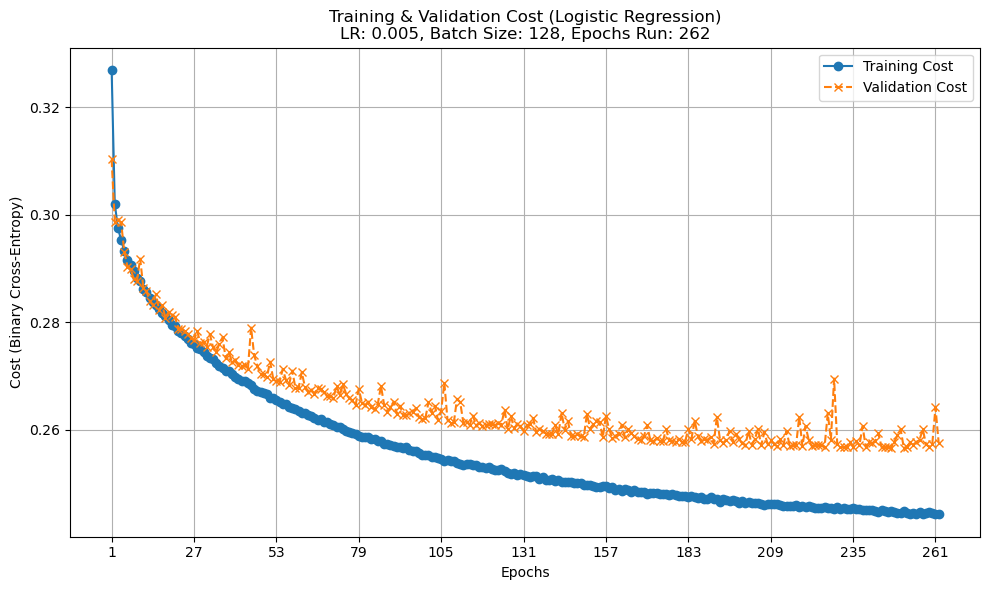


--- Summary of Final Results (Advanced Logistic Regression on Subset) ---
Learning Rate: 0.005, Configured Epochs: 1000
Epochs Run (due to early stopping or completion): 262
Mini-batch Size: 128
Overall Test Accuracy on Subset: 90.89%
F1-score (Target Class): 0.2753
Precision (Target Class): 0.6732
Recall (Target Class): 0.1730


In [63]:
if __name__ == "__main__":
    # Load and preprocess data
    (x_train_f, y_train_bin,
     x_val_f, y_val_bin,
     x_test_f, y_test_bin) = load_and_preprocess_data_logistic(validation_split_ratio=0.1)

    # Define Hyperparameters
    num_epochs_to_run = 1000      # Max number of epochs
    learning_rate_val = 0.005    # Learning rate
    minibatch_size_val = 128      # Size of mini-batches
    patience_val = 15            # Patience for early stopping
    print_every_n = 10           # How often to print cost

    # Train and evaluate the model
    results_advanced_logistic = logistic_regression_model(
        x_train_f, y_train_bin,
        x_val_f, y_val_bin,
        x_test_f, y_test_bin,
        num_epochs=num_epochs_to_run,
        minibatch_size=minibatch_size_val,
        learning_rate=learning_rate_val,
        patience_early_stopping=patience_val,
        print_cost_every_n_epochs=print_every_n
    )

    # Plot training and validation costs
    if results_advanced_logistic and "history" in results_advanced_logistic:
        plot_train_val_costs_logistic(results_advanced_logistic["history"],
                                      results_advanced_logistic["learning_rate"],
                                      results_advanced_logistic["minibatch_size"])
    else:
        print("Training was not completed successfully, skipping plotting.")


    # Print summary of final results
    print(f"\n--- Summary of Final Results (Advanced Logistic Regression on Subset) ---")
    if results_advanced_logistic:
        print(
            f"Learning Rate: {results_advanced_logistic['learning_rate']}, Configured Epochs: {results_advanced_logistic['num_epochs_configured']}")
        print(f"Epochs Run (due to early stopping or completion): {results_advanced_logistic['history']['epochs_run']}")
        print(f"Mini-batch Size: {results_advanced_logistic['minibatch_size']}")
        print(f"Overall Test Accuracy on Subset: {results_advanced_logistic['test_accuracy']:.2f}%")
        print(f"F1-score (Target Class): {results_advanced_logistic['f1_score']:.4f}")
        print(f"Precision (Target Class): {results_advanced_logistic['precision']:.4f}")
        print(f"Recall (Target Class): {results_advanced_logistic['recall']:.4f}")
    else:
        print("No results to display as training might have been interrupted or failed.")